In [26]:
import pandas as pd
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter


In [27]:
data = pd.read_csv("C:\\Users\\kothe\\Downloads\\train.csv\\train.csv")
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB
None

First 5 rows:
   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2       

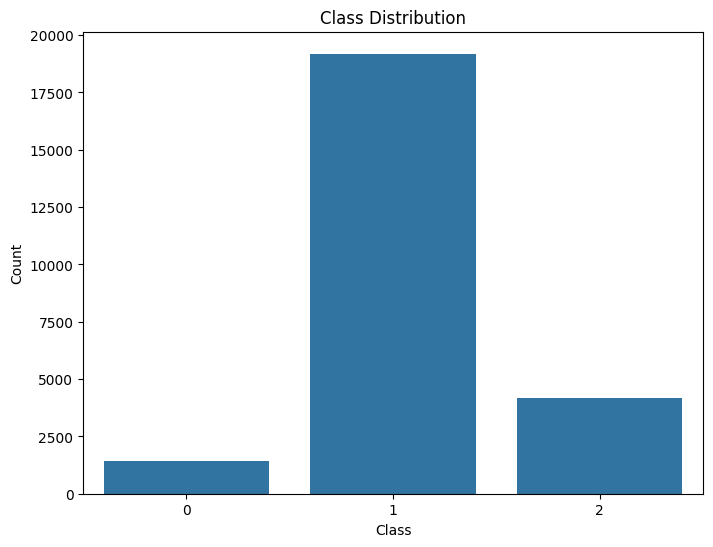

In [28]:
data['clean_text'] = data['tweet'].apply(preprocess_text)
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

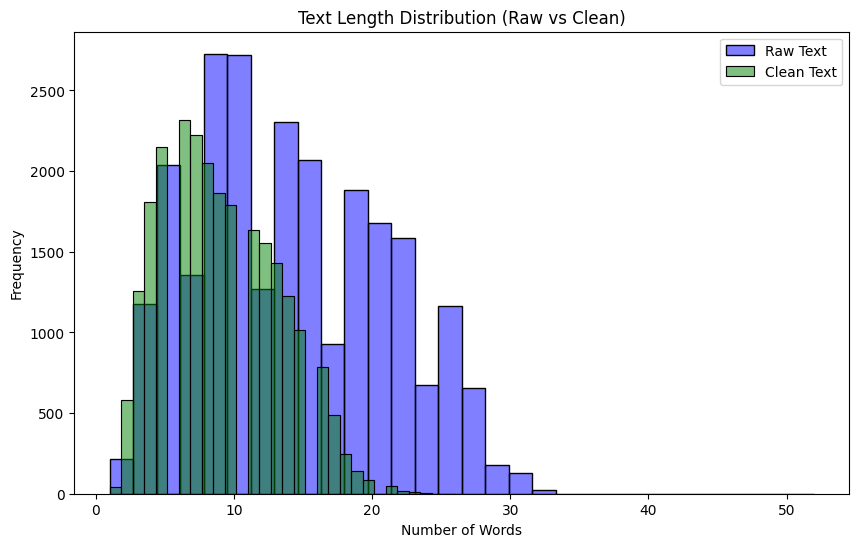

In [29]:
data['raw_length'] = data['tweet'].apply(lambda x: len(str(x).split()))
data['clean_length'] = data['clean_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['raw_length'], bins=30, color='blue', alpha=0.5, label='Raw Text')
sns.histplot(data['clean_length'], bins=30, color='green', alpha=0.5, label='Clean Text')
plt.title('Text Length Distribution (Raw vs Clean)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

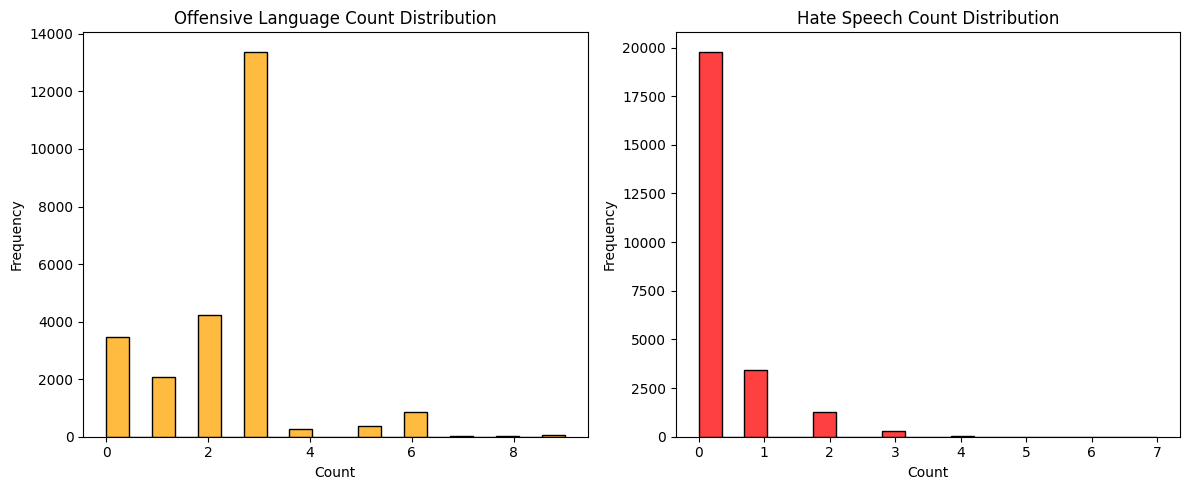

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['offensive_language_count'], bins=20, color='orange')
plt.title('Offensive Language Count Distribution')
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data['hate_speech_count'], bins=20, color='red')
plt.title('Hate Speech Count Distribution')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

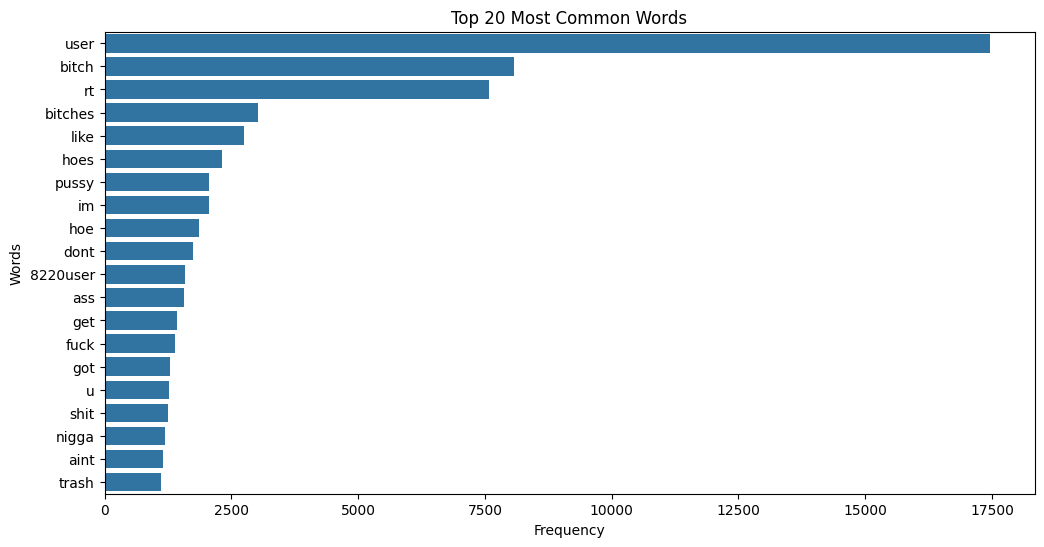

In [31]:
all_words = ' '.join(data['clean_text']).split()
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

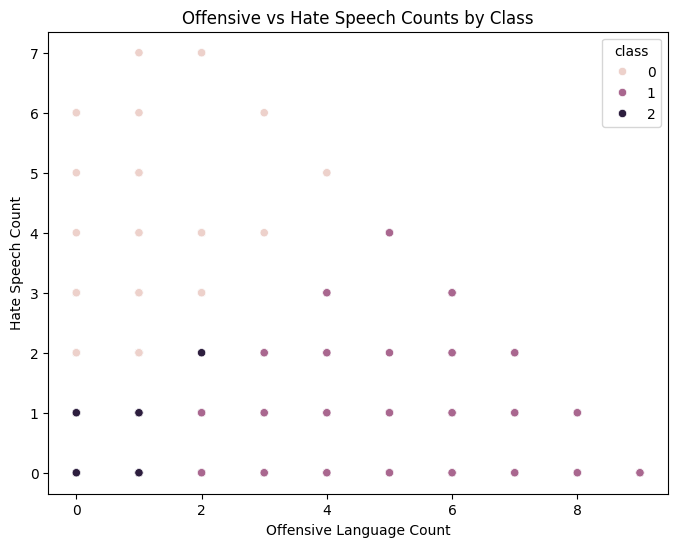

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='offensive_language_count', y='hate_speech_count', hue='class', data=data)
plt.title('Offensive vs Hate Speech Counts by Class')
plt.xlabel('Offensive Language Count')
plt.ylabel('Hate Speech Count')
plt.show()

<Axes: >

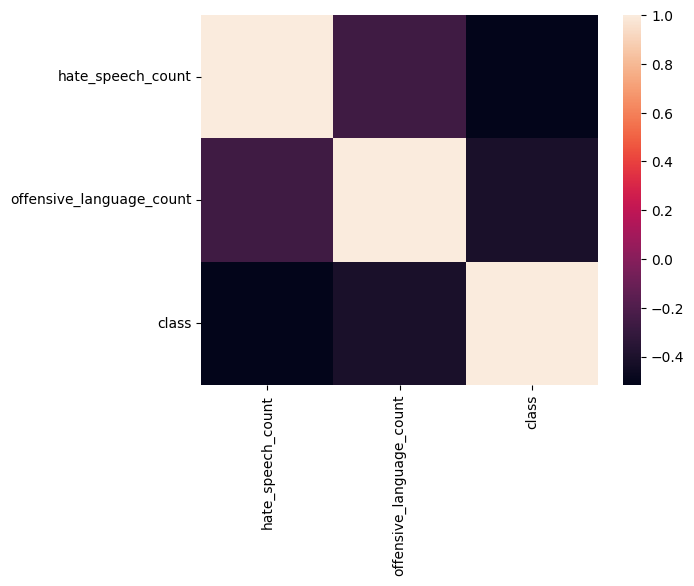

In [47]:
df=pd.read_csv("C:\\Users\\kothe\\Downloads\\train.csv\\train.csv",usecols=['class','offensive_language_count','hate_speech_count'])
a=df.corr()
sns.heatmap(a)

In [33]:

def preprocess_text(text):
    """Clean and preprocess text."""
    text = re.sub(r'@\w+', 'user', text)  # Replace user mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

data['clean_text'] = data['tweet'].apply(preprocess_text)




In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_text'])
vocab_size = len(tokenizer.word_index) + 1



In [35]:
sequences = tokenizer.texts_to_sequences(data['clean_text'])
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length)



In [36]:
y_class = to_categorical(data['class'], num_classes=3)
y_offensive = data['offensive_language_count'].values
y_hate = data['hate_speech_count'].values



In [37]:
X_train, X_test, y_train_class, y_test_class, y_train_offensive, y_test_offensive, y_train_hate, y_test_hate = train_test_split(
    X, y_class, y_offensive, y_hate, test_size=0.2, random_state=42)


In [38]:

input_layer = Input(shape=(max_length,))
embedding = Embedding(vocab_size, 128, input_length=max_length)(input_layer)
lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(embedding)
dropout = Dropout(0.5)(lstm)



c:\Program Files\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
output_class = Dense(3, activation='softmax', name='class_output')(dropout)
output_offensive = Dense(1, activation='relu', name='offensive_output')(dropout)
output_hate = Dense(1, activation='relu', name='hate_output')(dropout)

model = Model(inputs=input_layer, outputs=[output_class, output_offensive, output_hate])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'offensive_output': 'mse', 'hate_output': 'mse'},
    metrics={'class_output': 'accuracy', 'offensive_output': 'mae', 'hate_output': 'mae'}
)


In [40]:

model.fit(
    X_train, {'class_output': y_train_class, 'offensive_output': y_train_offensive, 'hate_output': y_train_hate},
    validation_data=(X_test, {'class_output': y_test_class, 'offensive_output': y_test_offensive, 'hate_output': y_test_hate}),
    epochs=10, batch_size=64
)




Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - class_output_accuracy: 0.7053 - class_output_loss: 0.7174 - hate_output_loss: 0.4883 - hate_output_mae: 0.3636 - loss: 3.6282 - offensive_output_loss: 2.4225 - offensive_output_mae: 1.1484 - val_class_output_accuracy: 0.8612 - val_class_output_loss: 0.3954 - val_hate_output_loss: 0.3750 - val_hate_output_mae: 0.3504 - val_loss: 1.8695 - val_offensive_output_loss: 1.1095 - val_offensive_output_mae: 0.6805
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - class_output_accuracy: 0.8956 - class_output_loss: 0.3339 - hate_output_loss: 0.4048 - hate_output_mae: 0.3810 - loss: 1.8427 - offensive_output_loss: 1.1041 - offensive_output_mae: 0.7013 - val_class_output_accuracy: 0.8725 - val_class_output_loss: 0.3647 - val_hate_output_loss: 0.3433 - val_hate_output_mae: 0.3341 - val_loss: 1.7756 - val_offensive_output_loss: 1.0764 - val_offensive_output_mae: 0.6582
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - class_output_acc

In [41]:
def predict_tweet(text):
    text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    pred_class, pred_offensive, pred_hate = model.predict(padded_sequence)
    class_labels = {0: "Hate Speech", 1: "Offensive", 2: "Neutral"}
    return {
        "Predicted Class": class_labels[pred_class.argmax()],
        "Offensive Language Count": round(float(pred_offensive[0][0]), 2),
        "Hate Speech Count": round(float(pred_hate[0][0]), 2)
    }

In [42]:
user_input =input("enter: ")
prediction = predict_tweet(user_input)
print(user_input)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
short people should leave the country
{'Predicted Class': 'Hate Speech', 'Offensive Language Count': 1.16, 'Hate Speech Count': 1.01}


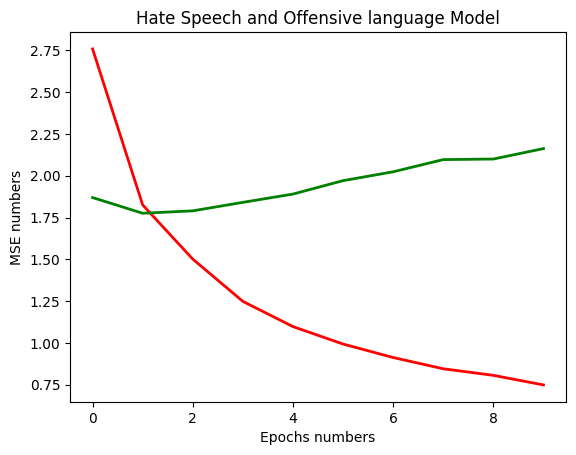

In [43]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()